In [53]:
# ============================================
# 1. INSTALL DEPENDENCY
# ============================================
!pip install yfinance flask pyngrok tensorflow scikit-learn matplotlib pandas numpy -q

print("="*60)
print("INSTALASI DEPENDENCY SELESAI")
print("="*60)


INSTALASI DEPENDENCY SELESAI


In [54]:
# ============================================
# 2. IMPORT LIBRARY
# ============================================
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
import os
import time
import base64
from io import BytesIO
import threading

# Machine Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Flask & Ngrok
from flask import Flask, render_template, request, jsonify, send_file
from pyngrok import ngrok

warnings.filterwarnings('ignore')

print("="*60)
print("IMPORT LIBRARY SELESAI")
print("="*60)

IMPORT LIBRARY SELESAI


In [55]:
# ============================================
# 3. FUNGSI DATA DAN PREPROCESSING
# ============================================

def download_data(ticker='ANTM.JK', start='2010-01-01', end='2025-12-31'):
    """
    Fungsi untuk mendownload data saham dari Yahoo Finance

    Parameters:
    -----------
    ticker : str
        Kode saham (default: ANTM.JK)
    start : str
        Tanggal mulai (YYYY-MM-DD)
    end : str
        Tanggal akhir (YYYY-MM-DD)

    Returns:
    --------
    DataFrame dengan kolom Date dan Close
    """
    print(f"Mendownload data {ticker} dari {start} sampai {end}...")

    # Download data
    data = yf.download(ticker, start=start, end=end, progress=False)

    # Reset index untuk mendapatkan Date sebagai kolom
    data.reset_index(inplace=True)

    # Ambil hanya kolom Date dan Close
    data = data[['Date', 'Close']]

    # Tangani missing values dengan forward fill
    data['Close'].fillna(method='ffill', inplace=True)

    print(f"Data berhasil didownload: {len(data)} baris")
    print(f"Rentang harga: Rp {data['Close'].min().item():.2f} - Rp {data['Close'].max().item():.2f}")

    return data

def prepare_data(data, window_size=60):
    """
    Fungsi untuk mempersiapkan data untuk training dan testing

    Parameters:
    -----------
    data : DataFrame
        Data saham dengan kolom Date dan Close
    window_size : int
        Ukuran window untuk sliding window (default: 60)

    Returns:
    --------
    Dictionary berisi data yang sudah diproses
    """
    print("\n" + "="*60)
    print("PREPROCESSING DATA")
    print("="*60)

    # Ambil harga penutupan
    prices = data['Close'].values.reshape(-1, 1)

    # Split data secara kronologis (80% training, 20% testing)
    train_size = int(len(prices) * 0.8)

    train_data = prices[:train_size]
    test_data = prices[train_size - window_size:]  # Ambil data untuk window

    print(f"Total data: {len(prices)} hari")
    print(f"Data training: {len(train_data)} hari ({len(train_data)/len(prices)*100:.1f}%)者に")
    print(f"Data testing: {len(prices[train_size:])} hari ({len(prices[train_size:])/len(prices)*100:.1f}%)者")

    # Scaling dengan MinMaxScaler (fit hanya pada training data)
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)

    print(f"Normalisasi data: Min={scaler.data_min_[0]:.4f}, Max={scaler.data_max_[0]:.4f}")

    # Fungsi untuk membuat dataset dengan sliding window
    def create_dataset(data, window_size):
        X, y = [], []
        for i in range(window_size, len(data)):
            X.append(data[i-window_size:i, 0])
            y.append(data[i, 0])
        return np.array(X), np.array(y)

    # Buat dataset training
    X_train, y_train = create_dataset(train_scaled, window_size)

    # Buat dataset testing
    X_test, y_test = create_dataset(test_scaled, window_size)

    # Reshape untuk LSTM: (samples, timesteps, features)
    X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    print(f"Shape X_train: {X_train.shape}")
    print(f"Shape X_train_lstm: {X_train_lstm.shape}")
    print(f"Shape y_train: {y_train.shape}")
    print(f"Shape X_test: {X_test.shape}")
    print(f"Shape X_test_lstm: {X_test_lstm.shape}")
    print(f"Shape y_test: {y_test.shape}")

    # Siapkan tanggal untuk plotting
    train_dates = data['Date'][window_size:train_size].values
    test_dates = data['Date'][train_size:].values

    # Harga asli untuk testing
    original_test_prices = prices[train_size:]

    return {
        'X_train': X_train,
        'X_train_lstm': X_train_lstm,
        'y_train': y_train,
        'X_test': X_test,
        'X_test_lstm': X_test_lstm,
        'y_test': y_test,
        'scaler': scaler,
        'train_dates': train_dates,
        'test_dates': test_dates,
        'original_test_prices': original_test_prices,
        'window_size': window_size,
        'train_size': train_size,
        'data_length': len(prices)
    }

In [56]:
# ============================================
# 4. MODEL LINEAR REGRESSION
# ============================================

def train_linear_regression(X_train, y_train):
    """
    Fungsi untuk melatih model Linear Regression
    """
    print("\n" + "="*60)
    print("TRAINING LINEAR REGRESSION")
    print("="*60)

    model = LinearRegression(fit_intercept=True)
    model.fit(X_train, y_train)

    print("Model Linear Regression selesai dilatih")
    print(f"Koefisien: {model.coef_[:5]} ... (5 dari {len(model.coef_)})")
    print(f"Intercept: {model.intercept_}")

    return model

def predict_linear_regression(model, X_test, y_test, scaler):
    """
    Fungsi untuk melakukan prediksi dengan Linear Regression
    """
    # Prediksi dalam skala normalized
    y_pred_scaled = model.predict(X_test)

    # Inverse transform ke skala asli
    y_pred_2d = y_pred_scaled.reshape(-1, 1)
    y_test_2d = y_test.reshape(-1, 1)

    # Buat dummy features untuk inverse transform
    dummy = np.zeros((len(y_pred_2d), 1))
    y_pred_combined = np.hstack((y_pred_2d, dummy))
    y_test_combined = np.hstack((y_test_2d, dummy))

    y_pred = scaler.inverse_transform(y_pred_combined)[:, 0]
    y_actual = scaler.inverse_transform(y_test_combined)[:, 0]

    # Hitung metrik evaluasi
    mae = mean_absolute_error(y_actual, y_pred)
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    r2 = r2_score(y_actual, y_pred)

    print("\n" + "-"*40)
    print("HASIL EVALUASI LINEAR REGRESSION")
    print("-"*40)
    print(f"MAE  : {mae:,.2f}")
    print(f"RMSE : {rmse:,.2f}")
    print(f"R²   : {r2:.4f}")

    return {
        'y_actual': y_actual,
        'y_pred': y_pred,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'model': model
    }

In [57]:
# ============================================
# 5. MODEL LSTM
# ============================================

def build_lstm_model(window_size):
    """
    Fungsi untuk membangun arsitektur LSTM
    """
    model = Sequential([
        # LSTM Layer 1 dengan return sequences
        LSTM(50, return_sequences=True, input_shape=(window_size, 1)),
        Dropout(0.2),

        # LSTM Layer 2
        LSTM(25, return_sequences=False),

        # Dense Layer
        Dense(16, activation='relu'),

        # Output Layer
        Dense(1, activation='linear')
    ])

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

def train_lstm_model(X_train, y_train, window_size):
    """
    Fungsi untuk melatih model LSTM
    """
    print("\n" + "="*60)
    print("TRAINING LSTM")
    print("="*60)

    # Bangun model
    model = build_lstm_model(window_size)

    print("Arsitektur LSTM:")
    model.summary()

    # Callback EarlyStopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    # Training model
    print("\nMemulai training LSTM...")
    start_time = time.time()

    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    training_time = time.time() - start_time
    print(f"\nTraining selesai dalam {training_time:.2f} detik")
    print(f"Epoch terakhir: {len(history.epoch)}")
    print(f"Final loss: {history.history['loss'][-1]:.6f}")
    print(f"Final val_loss: {history.history['val_loss'][-1]:.6f}")

    return model, history

def predict_lstm_model(model, X_test, y_test, scaler):
    """
    Fungsi untuk melakukan prediksi dengan LSTM
    """
    # Prediksi dalam skala normalized
    y_pred_scaled = model.predict(X_test, verbose=0).flatten()

    # Inverse transform ke skala asli
    y_pred_2d = y_pred_scaled.reshape(-1, 1)
    y_test_2d = y_test.reshape(-1, 1)

    # Buat dummy features untuk inverse transform
    dummy = np.zeros((len(y_pred_2d), 1))
    y_pred_combined = np.hstack((y_pred_2d, dummy))
    y_test_combined = np.hstack((y_test_2d, dummy))

    y_pred = scaler.inverse_transform(y_pred_combined)[:, 0]
    y_actual = scaler.inverse_transform(y_test_combined)[:, 0]

    # Hitung metrik evaluasi
    mae = mean_absolute_error(y_actual, y_pred)
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    r2 = r2_score(y_actual, y_pred)

    print("\n" + "-"*40)
    print("HASIL EVALUASI LSTM")
    print("-"*40)
    print(f"MAE  : {mae:,.2f}")
    print(f"RMSE : {rmse:,.2f}")
    print(f"R²   : {r2:.4f}")

    return {
        'y_actual': y_actual,
        'y_pred': y_pred,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'model': model
    }


In [58]:
# ============================================
# 6. FUNGSI VISUALISASI
# ============================================

def plot_results_lr(test_dates, y_actual, y_pred):
    """
    Plot hasil prediksi Linear Regression
    """
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_actual, label='Harga Aktual', linewidth=2)
    plt.plot(test_dates, y_pred, label='Prediksi Linear Regression', linewidth=2, linestyle='--')
    plt.title('Grafik 1: Perbandingan Harga Aktual vs Prediksi Linear Regression')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga (Rupiah)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_results_lstm(test_dates, y_actual, y_pred):
    """
    Plot hasil prediksi LSTM
    """
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_actual, label='Harga Aktual', linewidth=2)
    plt.plot(test_dates, y_pred, label='Prediksi LSTM', linewidth=2, linestyle='--')
    plt.title('Grafik 2: Perbandingan Harga Aktual vs Prediksi LSTM')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga (Rupiah)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_comparison(test_dates, y_actual, y_pred_lr, y_pred_lstm):
    """
    Plot perbandingan kedua model dalam satu grafik
    """
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_actual, label='Harga Aktual', linewidth=2)
    plt.plot(test_dates, y_pred_lr, label='Prediksi Linear Regression', linewidth=2, linestyle='--')
    plt.plot(test_dates, y_pred_lstm, label='Prediksi LSTM', linewidth=2, linestyle=':')
    plt.title('Grafik 3: Perbandingan Semua Model')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga (Rupiah)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [59]:
# ============================================
# 7. SETUP FLASK APP
# ============================================

# Buat direktori untuk template dan static
os.makedirs('/content/templates', exist_ok=True)
os.makedirs('/content/static', exist_ok=True)

# Template HTML untuk halaman index
index_html = """
<!DOCTYPE html>
<html lang="id">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Prediksi Saham ANTM - Skripsi</title>
    <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.1.3/dist/css/bootstrap.min.css" rel="stylesheet">
    <style>
        body {
            background: linear-gradient(135deg, #f5f7fa 0%, #c3cfe2 100%);
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
        }
        .navbar {
            background-color: #0a192f !important;
            box-shadow: 0 2px 10px rgba(0,0,0,0.1);
        }
        .navbar-brand {
            color: #ffffff !important;
            font-weight: 600;
        }
        .card {
            border-radius: 15px;
            box-shadow: 0 10px 30px rgba(0,0,0,0.1);
            border: none;
            margin-top: 30px;
        }
        .card-header {
            background-color: #800000;
            color: white;
            border-radius: 15px 15px 0 0 !important;
            font-weight: 600;
            padding: 20px;
        }
        .btn-primary {
            background-color: #800000;
            border: none;
            padding: 12px 30px;
            font-weight: 600;
            transition: all 0.3s ease;
        }
        .btn-primary:hover {
            background-color: #600000;
            transform: translateY(-2px);
            box-shadow: 0 5px 15px rgba(128,0,0,0.3);
        }
        .form-control, .form-select {
            border-radius: 10px;
            padding: 12px;
            border: 2px solid #e0e0e0;
        }
        .form-control:focus, .form-select:focus {
            border-color: #800000;
            box-shadow: 0 0 0 0.25rem rgba(128,0,0,0.25);
        }
        .loading {
            display: none;
            text-align: center;
            padding: 40px;
        }
        .spinner-border {
            width: 3rem;
            height: 3rem;
            color: #800000;
        }
        footer {
            background-color: #0a192f;
            color: white;
            padding: 20px 0;
            margin-top: 50px;
        }
        .info-card {
            background: white;
            border-radius: 10px;
            padding: 20px;
            margin: 20px 0;
            border-left: 5px solid #800000;
        }
    </style>
</head>
<body>
    <!-- Navbar -->
    <nav class="navbar navbar-expand-lg navbar-dark">
        <div class="container">
            <a class="navbar-brand" href="#">
                📈 Prediksi Saham ANTM
            </a>
            <span class="text-white-50">Skripsi - Analisis Perbandingan Algoritma</span>
        </div>
    </nav>

    <!-- Main Content -->
    <div class="container">
        <div class="row justify-content-center">
            <div class="col-md-8">
                <div class="card">
                    <div class="card-header text-center">
                        <h4 class="mb-0">🔍 Konfigurasi Prediksi</h4>
                    </div>
                    <div class="card-body p-4">
                        <form id="predictionForm" action="/predict" method="POST">
                            <!-- Input Kode Saham -->
                            <div class="mb-4">
                                <label class="form-label fw-bold">Kode Saham</label>
                                <input type="text" class="form-control" name="ticker" value="ANTM.JK" required>
                                <div class="form-text">Gunakan format Yahoo Finance (contoh: ANTM.JK, BBCA.JK)</div>
                            </div>

                            <!-- Pilihan Model -->
                            <div class="mb-4">
                                <label class="form-label fw-bold">Pilih Model</label>
                                <select class="form-select" name="model" required>
                                    <option value="comparison">📊 Perbandingan Linear Regression & LSTM</option>
                                    <option value="lr">📈 Linear Regression</option>
                                    <option value="lstm">🧠 LSTM</option>
                                </select>
                            </div>

                            <!-- Info Panel -->
                            <div class="info-card">
                                <h5>📌 Informasi Dataset:</h5>
                                <ul class="mb-0">
                                    <li>Sumber: Yahoo Finance (ANTM.JK)</li>
                                    <li>Periode: 2010 - 2025</li>
                                    <li>Window Size: 60 hari</li>
                                    <li>Split: 80% Training, 20% Testing</li>
                                </ul>
                            </div>

                            <!-- Tombol Submit -->
                            <div class="text-center mt-4">
                                <button type="submit" class="btn btn-primary btn-lg" onclick="showLoading()">
                                    🚀 Train & Predict
                                </button>
                            </div>
                        </form>

                        <!-- Loading Indicator -->
                        <div id="loading" class="loading">
                            <div class="spinner-border" role="status">
                                <span class="visually-hidden">Loading...</span>
                            </div>
                            <h5 class="mt-3">Melatih Model dan Melakukan Prediksi...</h5>
                            <p class="text-muted">Proses training LSTM membutuhkan waktu ~2-3 menit. Harap tunggu.</p>
                            <div class="progress mt-3">
                                <div class="progress-bar progress-bar-striped progress-bar-animated"
                                     style="width: 100%; background-color: #800000;"></div>
                            </div>
                        </div>
                    </div>
                </div>
            </div>
        </div>
    </div>

    <!-- Footer -->
    <footer class="text-center">
        <div class="container">
            <p class="mb-2">Analisis Perbandingan Akurasi Algoritma LSTM dan Linear Regression</p>
            <p class="mb-0">Prediksi Harga Penutupan Saham PT Aneka Tambang Tbk (ANTM)</p>
            <p class="mt-2"><small>© 2026 - Penelitian Skripsi || Erika Putri Dyatna</small></p>
        </div>
    </footer>

    <script>
        function showLoading() {
            document.getElementById('loading').style.display = 'block';
            document.querySelector('.card-body').style.opacity = '0.7';
        }
    </script>
</body>
</html>
"""

# Template HTML untuk halaman hasil
result_html = """
<!DOCTYPE html>
<html lang="id">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Hasil Prediksi - Skripsi</title>
    <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.1.3/dist/css/bootstrap.min.css" rel="stylesheet">
    <style>
        body {
            background: #f8f9fa;
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
        }
        .navbar {
            background-color: #0a192f !important;
        }
        .navbar-brand {
            color: white !important;
            font-weight: 600;
        }
        .result-header {
            background: linear-gradient(135deg, #0a192f 0%, #1a2a3f 100%);
            color: white;
            padding: 40px 0;
            margin-bottom: 30px;
        }
        .metric-card {
            background: white;
            border-radius: 15px;
            padding: 20px;
            margin: 10px 0;
            box-shadow: 0 5px 20px rgba(0,0,0,0.1);
            border-top: 5px solid #800000;
            transition: transform 0.3s ease;
        }
        .metric-card:hover {
            transform: translateY(-5px);
        }
        .metric-value {
            font-size: 2rem;
            font-weight: bold;
            color: #800000;
        }
        .metric-label {
            font-size: 0.9rem;
            color: #666;
            text-transform: uppercase;
        }
        .best-model {
            background: linear-gradient(135deg, #28a745 0%, #20c997 100%);
            color: white;
            padding: 30px;
            border-radius: 15px;
            margin: 30px 0;
        }
        .prediction-box {
            background: #0a192f;
            color: white;
            padding: 30px;
            border-radius: 15px;
            text-align: center;
            margin: 20px 0;
        }
        .prediction-value {
            font-size: 3rem;
            font-weight: bold;
            color: #ffc107;
        }
        .btn-back {
            background-color: #800000;
            color: white;
            padding: 15px 40px;
            border-radius: 30px;
            font-weight: 600;
            transition: all 0.3s ease;
        }
        .btn-back:hover {
            background-color: #600000;
            transform: translateY(-2px);
            color: white;
        }
        table {
            background: white;
            border-radius: 10px;
            overflow: hidden;
            box-shadow: 0 5px 15px rgba(0,0,0,0.1);
        }
        thead {
            background-color: #0a192f;
            color: white;
        }
        footer {
            background-color: #0a192f;
            color: white;
            padding: 20px 0;
            margin-top: 50px;
        }
        img {
            border-radius: 10px;
            box-shadow: 0 5px 20px rgba(0,0,0,0.1);
            max-width: 100%;
            height: auto;
        }
    </style>
</head>
<body>
    <!-- Navbar -->
    <nav class="navbar navbar-expand-lg navbar-dark">
        <div class="container">
            <a class="navbar-brand" href="/">← Kembali ke Beranda</a>
        </div>
    </nav>

    <!-- Result Header -->
    <div class="result-header text-center">
        <div class="container">
            <h1>📊 Hasil Prediksi Saham {{ ticker }}</h1>
            <p class="lead">Periode Data: 2010 - 2025 | Model:
                {% if model == 'comparison' %}Perbandingan Linear Regression & LSTM
                {% elif model == 'lr' %}Linear Regression
                {% else %}LSTM{% endif %}
            </p>
        </div>
    </div>

    <div class="container">
        {% if error %}
        <div class="alert alert-danger text-center">
            <h4>❌ Terjadi Kesalahan</h4>
            <p>{{ error }}</p>
        </div>
        {% else %}

        <!-- Metrics Cards -->
        <div class="row mt-4">
            {% if results.lr %}
            <div class="col-md-6">
                <div class="metric-card text-center">
                    <h4 class="mb-4">📈 Linear Regression</h4>
                    <div class="row">
                        <div class="col-4">
                            <div class="metric-label">MAE</div>
                            <div class="metric-value"> {{ "%.2f"|format(results.lr.mae) }}</div>
                        </div>
                        <div class="col-4">
                            <div class="metric-label">RMSE</div>
                            <div class="metric-value"> {{ "%.2f"|format(results.lr.rmse) }}</div>
                        </div>
                        <div class="col-4">
                            <div class="metric-label">R²</div>
                            <div class="metric-value">{{ "%.4f"|format(results.lr.r2) }}</div>
                        </div>
                    </div>
                </div>
            </div>
            {% endif %}

            {% if results.lstm %}
            <div class="col-md-6">
                <div class="metric-card text-center">
                    <h4 class="mb-4">🧠 LSTM</h4>
                    <div class="row">
                        <div class="col-4">
                            <div class="metric-label">MAE</div>
                            <div class="metric-value"> {{ "%.2f"|format(results.lstm.mae) }}</div>
                        </div>
                        <div class="col-4">
                            <div class="metric-label">RMSE</div>
                            <div class="metric-value"> {{ "%.2f"|format(results.lstm.rmse) }}</div>
                        </div>
                        <div class="col-4">
                            <div class="metric-label">R²</div>
                            <div class="metric-value">{{ "%.4f"|format(results.lstm.r2) }}</div>
                        </div>
                    </div>
                </div>
            </div>
            {% endif %}
        </div>

        <!-- Best Model -->
        {% if best_model %}
        <div class="best-model text-center">
            <h3>🏆 Model Terbaik: {{ best_model }}</h3>
            <p class="mb-0">Berdasarkan nilai RMSE terendah</p>
        </div>
        {% endif %}

        <!-- Next Price Prediction -->
        {% if next_price %}
        <div class="prediction-box">
            <h4>🔮 Prediksi Harga Penutupan Berikutnya</h4>
            <div class="prediction-value">Rp {{ "%.2f"|format(next_price) }}</div>
            <p class="mb-0 mt-3">Berdasarkan model {% if model == 'lr' %}Linear Regression
                {% elif model == 'lstm' %}LSTM{% else %}terbaik{% endif %}</p>
        </div>
        {% endif %}

        <!-- Comparison Table -->
        {% if results.lr and results.lstm %}
        <div class="row mt-5">
            <div class="col-md-8 mx-auto">
                <h3 class="text-center mb-4">📋 Perbandingan Metrik Evaluasi</h3>
                <table class="table table-bordered">
                    <thead>
                        <tr>
                            <th>Metrik</th>
                            <th>Linear Regression</th>
                            <th>LSTM</th>
                            <th>Model Terbaik</th>
                        </tr>
                    </thead>
                    <tbody>
                        <tr>
                            <td>MAE</td>
                            <td> {{ "%.2f"|format(results.lr.mae) }}</td>
                            <td> {{ "%.2f"|format(results.lstm.mae) }}</td>
                            <td>{% if results.lr.mae < results.lstm.mae %}Linear Regression{% else %}LSTM{% endif %}</td>
                        </tr>
                        <tr>
                            <td>RMSE</td>
                            <td> {{ "%.2f"|format(results.lr.rmse) }}</td>
                            <td> {{ "%.2f"|format(results.lstm.rmse) }}</td>
                            <td>{% if results.lr.rmse < results.lstm.rmse %}Linear Regression{% else %}LSTM{% endif %}</td>
                        </tr>
                        <tr>
                            <td>R²</td>
                            <td>{{ "%.4f"|format(results.lr.r2) }}</td>
                            <td>{{ "%.4f"|format(results.lstm.r2) }}</td>
                            <td>{% if results.lr.r2 > results.lstm.r2 %}Linear Regression{% else %}LSTM{% endif %}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
        </div>
        {% endif %}

        <!-- Graphs Section -->
        <div class="row mt-5">
            <div class="col-12 text-center mb-4">
                <h3>📈 Grafik Hasil Prediksi</h3>
                <p class="text-muted">Berikut adalah visualisasi dari hasil prediksi yang telah dilakukan</p>
            </div>

            {% if plots.lr %}
            <div class="col-12 mb-5">
                <h5>Grafik 1: Linear Regression</h5>
                <img src="data:image/png;base64,{{ plots.lr }}" class="img-fluid" alt="Linear Regression Plot">
            </div>
            {% endif %}

            {% if plots.lstm %}
            <div class="col-12 mb-5">
                <h5>Grafik 2: LSTM</h5>
                <img src="data:image/png;base64,{{ plots.lstm }}" class="img-fluid" alt="LSTM Plot">
            </div>
            {% endif %}

            {% if plots.comparison %}
            <div class="col-12 mb-5">
                <h5>Grafik 3: Perbandingan Semua Model</h5>
                <img src="data:image/png;base64,{{ plots.comparison }}" class="img-fluid" alt="Comparison Plot">
            </div>
            {% endif %}
        </div>

        {% endif %}

        <!-- Back Button -->
        <div class="text-center my-5">
            <a href="/" class="btn btn-back">🔄 Lakukan Prediksi Baru</a>
        </div>
    </div>

    <!-- Footer -->
    <footer class="text-center">
        <div class="container">
            <p>Analisis Perbandingan Akurasi Algoritma LSTM dan Linear Regression</p>
            <p class="mb-0"><small>Prediksi Harga Penutupan Saham PT Aneka Tambang Tbk (ANTM)</small></p>
        </div>
    </footer>
</body>
</html>
"""

# Simpan template HTML
with open('/content/templates/index.html', 'w', encoding='utf-8') as f:
    f.write(index_html)

with open('/content/templates/result.html', 'w', encoding='utf-8') as f:
    f.write(result_html)

print("="*60)
print("TEMPLATE HTML BERHASIL DIBUAT")
print("="*60)

TEMPLATE HTML BERHASIL DIBUAT


In [60]:
# ============================================
# 8. FLASK APPLICATION
# ============================================

app = Flask(__name__, template_folder='/content/templates')

# Global variables untuk menyimpan hasil
global_data = None
global_results = {}
global_plots = {}

def fig_to_base64(fig):
    """Convert matplotlib figure to base64 string"""
    buf = BytesIO()
    fig.savefig(buf, format='png', dpi=100, bbox_inches='tight')
    buf.seek(0)
    img_base64 = base64.b64encode(buf.getvalue()).decode('utf-8')
    buf.close()
    plt.close(fig)
    return img_base64

@app.route('/')
def index():
    """Halaman utama"""
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    """Endpoint untuk melakukan prediksi"""
    global global_data, global_results, global_plots

    try:
        # Ambil parameter dari form
        ticker = request.form.get('ticker', 'ANTM.JK')
        model_choice = request.form.get('model', 'comparison')

        # Download data
        data = download_data(ticker)

        # Preprocessing
        processed = prepare_data(data)
        global_data = processed

        # Dictionary untuk menyimpan hasil
        results = {}
        plots = {}
        next_price = None

        # Train dan evaluasi sesuai pilihan
        if model_choice in ['lr', 'comparison']:
            # Linear Regression
            lr_model = train_linear_regression(processed['X_train'], processed['y_train'])
            lr_results = predict_linear_regression(lr_model, processed['X_test'], processed['y_test'], processed['scaler'])
            results['lr'] = lr_results

            # Plot Linear Regression
            fig1 = plt.figure(figsize=(12, 6))
            plt.plot(processed['test_dates'], lr_results['y_actual'], label='Aktual', linewidth=2)
            plt.plot(processed['test_dates'], lr_results['y_pred'], label='Prediksi Linear Regression', linewidth=2, linestyle='--')
            plt.title('Grafik 1: Perbandingan Harga Aktual vs Prediksi Linear Regression')
            plt.xlabel('Tanggal')
            plt.ylabel('Harga (Rupiah)')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plots['lr'] = fig_to_base64(fig1)

        if model_choice in ['lstm', 'comparison']:
            # LSTM
            lstm_model, history = train_lstm_model(processed['X_train_lstm'], processed['y_train'], processed['window_size'])
            lstm_results = predict_lstm_model(lstm_model, processed['X_test_lstm'], processed['y_test'], processed['scaler'])
            results['lstm'] = lstm_results

            # Plot LSTM
            fig2 = plt.figure(figsize=(12, 6))
            plt.plot(processed['test_dates'], lstm_results['y_actual'], label='Aktual', linewidth=2)
            plt.plot(processed['test_dates'], lstm_results['y_pred'], label='Prediksi LSTM', linewidth=2, linestyle='--')
            plt.title('Grafik 2: Perbandingan Harga Aktual vs Prediksi LSTM')
            plt.xlabel('Tanggal')
            plt.ylabel('Harga (Rupiah)')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plots['lstm'] = fig_to_base64(fig2)

        # Plot perbandingan jika kedua model ada
        if model_choice == 'comparison' and 'lr' in results and 'lstm' in results:
            fig3 = plt.figure(figsize=(12, 6))
            plt.plot(processed['test_dates'], results['lr']['y_actual'], label='Aktual', linewidth=2)
            plt.plot(processed['test_dates'], results['lr']['y_pred'], label='Prediksi Linear Regression', linewidth=2, linestyle='--')
            plt.plot(processed['test_dates'], results['lstm']['y_pred'], label='Prediksi LSTM', linewidth=2, linestyle=':')
            plt.title('Grafik 3: Perbandingan Semua Model')
            plt.xlabel('Tanggal')
            plt.ylabel('Harga (Rupiah)')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plots['comparison'] = fig_to_base64(fig3)

        # Tentukan model terbaik berdasarkan RMSE
        best_model = None
        if model_choice == 'comparison' and 'lr' in results and 'lstm' in results:
            if results['lr']['rmse'] < results['lstm']['rmse']:
                best_model = 'Linear Regression'
            else:
                best_model = 'LSTM'

            # Prediksi harga berikutnya menggunakan model terbaik
            if best_model == 'Linear Regression':
                last_window = processed['X_test'][-1].reshape(1, -1)
                next_pred_scaled = results['lr']['model'].predict(last_window)[0]
            else:
                last_window = processed['X_test_lstm'][-1].reshape(1, processed['window_size'], 1)
                next_pred_scaled = results['lstm']['model'].predict(last_window, verbose=0)[0, 0]

            # Inverse transform
            next_pred_2d = np.array([[next_pred_scaled, 0]])
            next_price = processed['scaler'].inverse_transform(next_pred_2d)[0, 0]

        # Simpan global results
        global_results = results
        global_plots = plots

        return render_template('result.html',
                             ticker=ticker,
                             model=model_choice,
                             results=results,
                             plots=plots,
                             best_model=best_model,
                             next_price=next_price)

    except Exception as e:
        return render_template('result.html', error=str(e))

In [61]:
# ============================================
# 9. FUNGSI UNTUK MENAMPILKAN PLOT DI NOTEBOOK
# ============================================

def run_notebook_analysis():
    """
    Fungsi untuk menjalankan analisis langsung di notebook
    (akan dipanggil setelah Flask server berjalan)
    """
    print("\n" + "="*70)
    print("ANALISIS PERBANDINGAN ALGORITMA - HASIL DI NOTEBOOK")
    print("="*70)

    # Download data
    data = download_data()

    # Preprocessing
    processed = prepare_data(data)

    # Train Linear Regression
    lr_model = train_linear_regression(processed['X_train'], processed['y_train'])
    lr_results = predict_linear_regression(lr_model, processed['X_test'], processed['y_test'], processed['scaler'])

    # Train LSTM
    lstm_model, history = train_lstm_model(processed['X_train_lstm'], processed['y_train'], processed['window_size'])
    lstm_results = predict_lstm_model(lstm_model, processed['X_test_lstm'], processed['y_test'], processed['scaler'])

    # Tampilkan plot
    print("\n" + "="*70)
    print("GRAFIK HASIL PREDIKSI")
    print("="*70)

    # Plot 1: Linear Regression
    plot_results_lr(processed['test_dates'], lr_results['y_actual'], lr_results['y_pred'])

    # Plot 2: LSTM
    plot_results_lstm(processed['test_dates'], lstm_results['y_actual'], lstm_results['y_pred'])

    # Plot 3: Perbandingan
    plot_comparison(processed['test_dates'], lr_results['y_actual'], lr_results['y_pred'], lstm_results['y_pred'])

    # Tampilkan perbandingan metrik
    print("\n" + "="*70)
    print("TABEL PERBANDINGAN METRIK EVALUASI")
    print("="*70)
    print(f"{'Metrik':<15} {'Linear Regression':<25} {'LSTM':<25}")
    print("-"*65)
    print(f"{'MAE':<15}  {lr_results['mae']:<22,.2f}  {lstm_results['mae']:<22,.2f}")
    print(f"{'RMSE':<15}  {lr_results['rmse']:<22,.2f}  {lstm_results['rmse']:<22,.2f}")
    print(f"{'R²':<15} {lr_results['r2']:<25.4f} {lstm_results['r2']:<25.4f}")
    print("-"*65)

    # Tentukan model terbaik
    if lr_results['rmse'] < lstm_results['rmse']:
        print(f"\n✅ Model Terbaik: Linear Regression (RMSE lebih rendah)")
    else:
        print(f"\n✅ Model Terbaik: LSTM (RMSE lebih rendah)")


MEMULAI FLASK SERVER DENGAN NGROK

🌐 PUBLIC URL: NgrokTunnel: "https://37dc-34-148-20-221.ngrok-free.app" -> "http://localhost:5000"

📱 Buka URL di atas untuk mengakses aplikasi web
⏳ Server akan berjalan selama session Colab aktif


ANALISIS PERBANDINGAN ALGORITMA - HASIL DI NOTEBOOK
Mendownload data ANTM.JK dari 2010-01-01 sampai 2025-12-31...
Data berhasil didownload: 3937 baris
Rentang harga: Rp 231.39 - Rp 3670.00

PREPROCESSING DATA
Total data: 3937 hari
Data training: 3149 hari (80.0%)者に
Data testing: 788 hari (20.0%)者
Normalisasi data: Min=231.3919, Max=2631.8145
Shape X_train: (3089, 60)
Shape X_train_lstm: (3089, 60, 1)
Shape y_train: (3089,)
Shape X_test: (788, 60)
Shape X_test_lstm: (788, 60, 1)
Shape y_test: (788,)

TRAINING LINEAR REGRESSION
Model Linear Regression selesai dilatih
Koefisien: [ 0.00611789 -0.01526934 -0.01295839  0.0449899   0.01641079] ... (5 dari 60)
Intercept: 0.0007195084016993203

----------------------------------------
HASIL EVALUASI LINEAR REGRESS

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,433 (72.00 KB)

 Trainable params: 18,433 (72.00 KB)

 Non-trainable params: 0 (0.00 B)


Memulai training LSTM...
Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.0209 - mae: 0.0862 - val_loss: 0.0049 - val_mae: 0.0478
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0010 - mae: 0.0192 - val_loss: 0.0045 - val_mae: 0.0470
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0013 - mae: 0.0196 - val_loss: 0.0040 - val_mae: 0.0430
Epoch 4/100
59/78 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0014 - mae: 0.0189

78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0013 - mae: 0.0187 - val_loss: 0.0036 - val_mae: 0.0415
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 9.7430e-04 - mae: 0.0175 - val_loss: 0.0033 - val_mae: 0.0392
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0011 - mae: 0.0172 - val_loss: 0.0031 - val_mae: 0.0384
Epoch 7/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0010 - mae: 0.0172 - val_loss: 0.0029 - val_mae: 0.0374
Epoch 8/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 9.0286e-04 - mae: 0.0158 - val_loss: 0.0027 - val_mae: 0.0352
Epoch 9/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 6.8230e-04 - mae: 0.0155 - val_loss: 0.0025 - val_mae: 0.0337
Epoch 10/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 6.0877e-04 - mae: 0.0149 - val_loss: 0.0023 - val_mae: 0.0328
Epoch 11/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 5.7080e-04 - mae: 0.0139 - val_loss: 0.0024 - val_mae: 0.0328
Epoch 12/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 66m

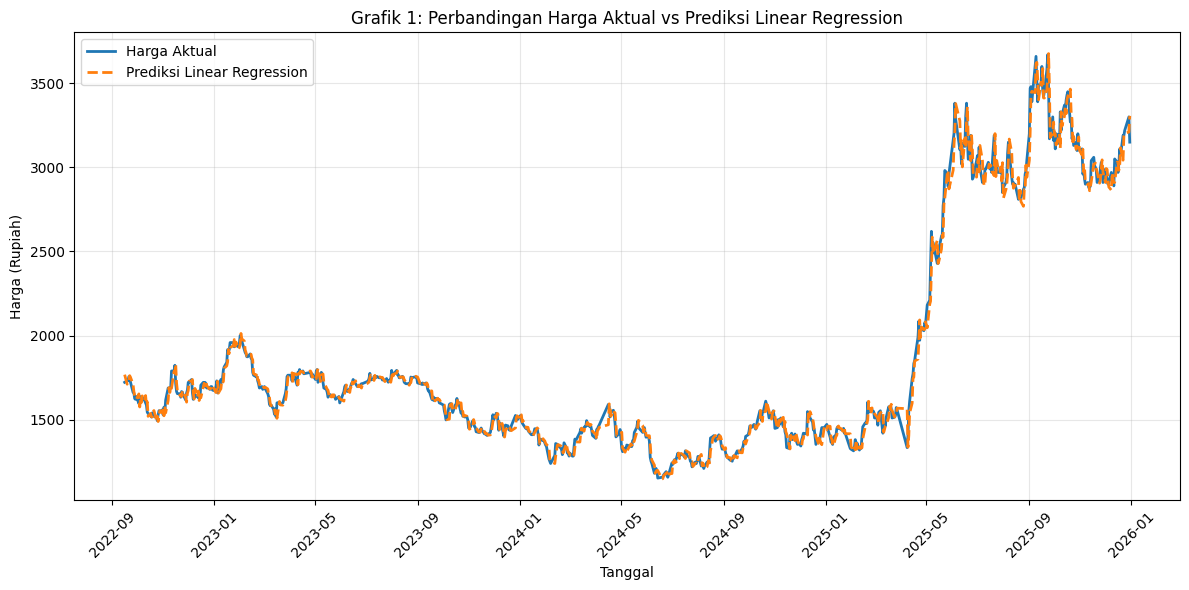

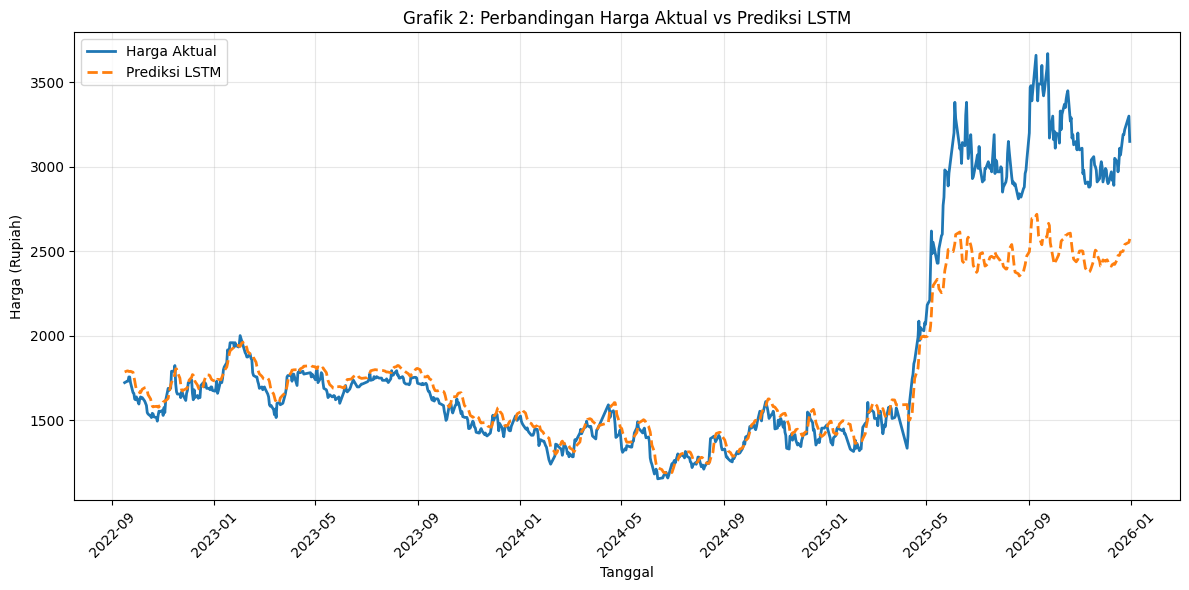

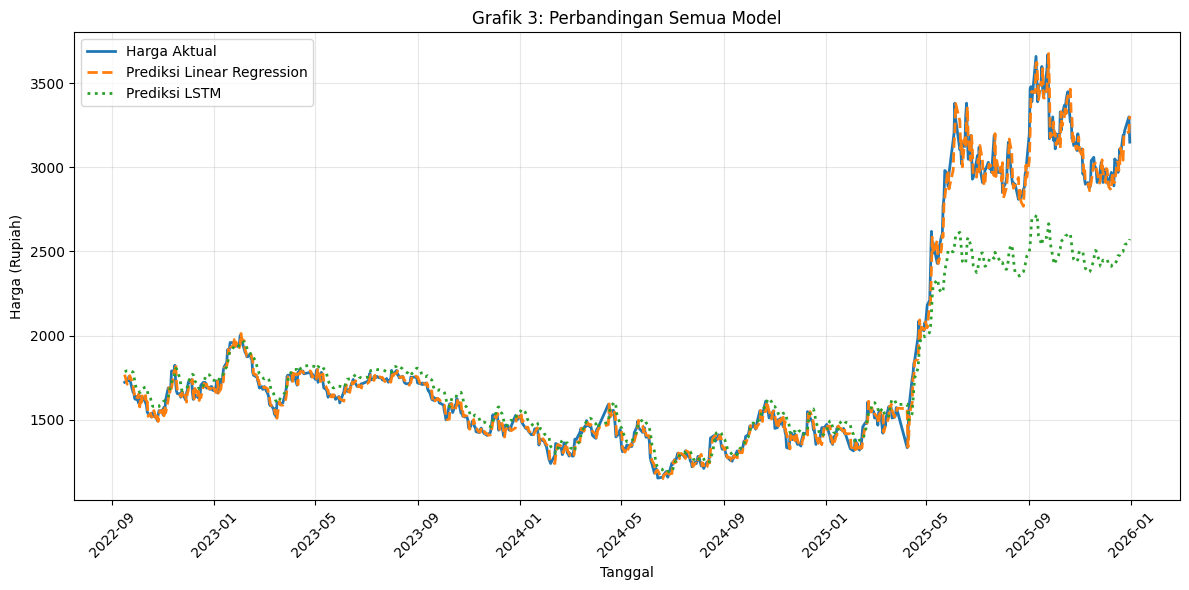


TABEL PERBANDINGAN METRIK EVALUASI
Metrik          Linear Regression         LSTM                     
-----------------------------------------------------------------
MAE              35.83                   164.59                
RMSE             55.64                   285.84                
R²              0.9926                    0.8041                   
-----------------------------------------------------------------

✅ Model Terbaik: Linear Regression (RMSE lebih rendah)

MENJALANKAN FLASK SERVER...
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [21/Feb/2026 09:28:20] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Feb/2026 09:28:21] "GET /favicon.ico HTTP/1.1" 404 -


Mendownload data ANTM.JK dari 2010-01-01 sampai 2025-12-31...
Data berhasil didownload: 3937 baris
Rentang harga: Rp 231.39 - Rp 3670.00

PREPROCESSING DATA
Total data: 3937 hari
Data training: 3149 hari (80.0%)者に
Data testing: 788 hari (20.0%)者
Normalisasi data: Min=231.3919, Max=2631.8145
Shape X_train: (3089, 60)
Shape X_train_lstm: (3089, 60, 1)
Shape y_train: (3089,)
Shape X_test: (788, 60)
Shape X_test_lstm: (788, 60, 1)
Shape y_test: (788,)

TRAINING LINEAR REGRESSION
Model Linear Regression selesai dilatih
Koefisien: [ 0.00611789 -0.01526934 -0.01295839  0.0449899   0.01641079] ... (5 dari 60)
Intercept: 0.0007195084016993203

----------------------------------------
HASIL EVALUASI LINEAR REGRESSION
----------------------------------------
MAE  : 35.83
RMSE : 55.64
R²   : 0.9926

TRAINING LSTM
Arsitektur LSTM:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,433 (72.00 KB)

 Trainable params: 18,433 (72.00 KB)

 Non-trainable params: 0 (0.00 B)


Memulai training LSTM...
Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0219 - mae: 0.0878 - val_loss: 0.0050 - val_mae: 0.0472
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0013 - mae: 0.0196 - val_loss: 0.0048 - val_mae: 0.0467
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0012 - mae: 0.0193 - val_loss: 0.0050 - val_mae: 0.0481
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 9.7448e-04 - mae: 0.0185 - val_loss: 0.0039 - val_mae: 0.0429
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0012 - mae: 0.0186 - val_loss: 0.0044 - val_mae: 0.0462
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 9.4796e-04 - mae: 0.0182 - val_loss: 0.0034 - val_mae: 0.0395
Epoch 7/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 9.6709e-04 - mae: 0.0155 - val_loss: 0.0031 - val_mae: 0.0376
Epoch 8/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 9.0131e-04 - mae: 0.0161 - val_loss: 0.0028 - val_mae: 0.0360
Epoch 9/100
78

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,433 (72.00 KB)

 Trainable params: 18,433 (72.00 KB)

 Non-trainable params: 0 (0.00 B)


Memulai training LSTM...
53/78 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 6.9247e-04 - mae: 0.0119Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 5.7460e-04 - mae: 0.0113 - val_loss: 9.3642e-04 - val_mae: 0.0218
Epoch 60/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - loss: 4.2818e-04 - mae: 0.0108 - val_loss: 0.0011 - val_mae: 0.0215
Epoch 61/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 17s 111ms/step - loss: 0.0234 - mae: 0.0904 - val_loss: 0.0041 - val_mae: 0.0439
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - loss: 5.4766e-04 - mae: 0.0108 - val_loss: 9.4124e-04 - val_mae: 0.0204
Epoch 62/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - loss: 0.0013 - mae: 0.0183 - val_loss: 0.0040 - val_mae: 0.0443
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 4.2863e-04 - mae: 0.0102 - val_loss: 9.6024e-04 - val_mae: 0.0208
Epoch 63/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 9.5676e-04 - mae: 0.0172 - val_loss: 0.0037 - val_mae: 0.0423
Epoch 4/100
78/78 ━━━━━━━━━━━━━━

INFO:werkzeug:127.0.0.1 - - [21/Feb/2026 09:36:14] "POST /predict HTTP/1.1" 200 -


78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 8.8901e-04 - mae: 0.0156 - val_loss: 0.0016 - val_mae: 0.0269
Epoch 17/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 8.8107e-04 - mae: 0.0141 - val_loss: 0.0016 - val_mae: 0.0265
Epoch 18/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 5.6534e-04 - mae: 0.0136 - val_loss: 0.0015 - val_mae: 0.0269
Epoch 19/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 5.2567e-04 - mae: 0.0129 - val_loss: 0.0015 - val_mae: 0.0259
Epoch 20/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 5.4427e-04 - mae: 0.0131 - val_loss: 0.0016 - val_mae: 0.0282
Epoch 21/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 5.4671e-04 - mae: 0.0127 - val_loss: 0.0014 - val_mae: 0.0262
Epoch 22/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 4.7810e-04 - mae: 0.0115 - val_loss: 0.0016 - val_mae: 0.0289
Epoch 23/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 4.3201e-04 - mae: 0.0114 - val_loss: 0.0014 - val_mae: 0.0253
Epoch 24/100
78/78 ━━━━━━━━━━

INFO:werkzeug:127.0.0.1 - - [21/Feb/2026 09:39:36] "POST /predict HTTP/1.1" 200 -


Mendownload data ANTM.JK dari 2010-01-01 sampai 2025-12-31...
Data berhasil didownload: 3937 baris
Rentang harga: Rp 231.39 - Rp 3670.00

PREPROCESSING DATA
Total data: 3937 hari
Data training: 3149 hari (80.0%)者に
Data testing: 788 hari (20.0%)者
Normalisasi data: Min=231.3919, Max=2631.8145
Shape X_train: (3089, 60)
Shape X_train_lstm: (3089, 60, 1)
Shape y_train: (3089,)
Shape X_test: (788, 60)
Shape X_test_lstm: (788, 60, 1)
Shape y_test: (788,)

TRAINING LINEAR REGRESSION
Model Linear Regression selesai dilatih
Koefisien: [ 0.00611789 -0.01526934 -0.01295839  0.0449899   0.01641079] ... (5 dari 60)
Intercept: 0.0007195084016993203

----------------------------------------
HASIL EVALUASI LINEAR REGRESSION
----------------------------------------
MAE  : 35.83
RMSE : 55.64
R²   : 0.9926

TRAINING LSTM
Arsitektur LSTM:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,433 (72.00 KB)

 Trainable params: 18,433 (72.00 KB)

 Non-trainable params: 0 (0.00 B)


Memulai training LSTM...
Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.0331 - mae: 0.1111 - val_loss: 0.0051 - val_mae: 0.0489
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0012 - mae: 0.0188 - val_loss: 0.0048 - val_mae: 0.0483
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0014 - mae: 0.0199 - val_loss: 0.0042 - val_mae: 0.0444
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0012 - mae: 0.0176 - val_loss: 0.0040 - val_mae: 0.0441
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 8.7307e-04 - mae: 0.0179 - val_loss: 0.0037 - val_mae: 0.0416
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 7.2220e-04 - mae: 0.0168 - val_loss: 0.0051 - val_mae: 0.0530
Epoch 7/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0010 - mae: 0.0182 - val_loss: 0.0030 - val_mae: 0.0383
Epoch 8/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0011 - mae: 0.0185 - val_loss: 0.0032 - val_mae: 0.0391
Epoch 9/100
78/78 ━━━

INFO:werkzeug:127.0.0.1 - - [21/Feb/2026 09:46:51] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Feb/2026 10:22:20] "GET / HTTP/1.1" 200 -


Mendownload data ANTM.JK dari 2010-01-01 sampai 2025-12-31...
Data berhasil didownload: 3937 baris
Rentang harga: Rp 231.39 - Rp 3670.00

PREPROCESSING DATA
Total data: 3937 hari
Data training: 3149 hari (80.0%)者に
Data testing: 788 hari (20.0%)者
Normalisasi data: Min=231.3919, Max=2631.8145
Shape X_train: (3089, 60)
Shape X_train_lstm: (3089, 60, 1)
Shape y_train: (3089,)
Shape X_test: (788, 60)
Shape X_test_lstm: (788, 60, 1)
Shape y_test: (788,)

TRAINING LINEAR REGRESSION
Model Linear Regression selesai dilatih
Koefisien: [ 0.00611789 -0.01526934 -0.01295839  0.0449899   0.01641079] ... (5 dari 60)
Intercept: 0.0007195084016993203

----------------------------------------
HASIL EVALUASI LINEAR REGRESSION
----------------------------------------
MAE  : 35.83
RMSE : 55.64
R²   : 0.9926


INFO:werkzeug:127.0.0.1 - - [21/Feb/2026 10:22:48] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Feb/2026 10:23:01] "GET / HTTP/1.1" 200 -


Mendownload data ANTM.JK dari 2010-01-01 sampai 2025-12-31...
Data berhasil didownload: 3937 baris
Rentang harga: Rp 231.39 - Rp 3670.00

PREPROCESSING DATA
Total data: 3937 hari
Data training: 3149 hari (80.0%)者に
Data testing: 788 hari (20.0%)者
Normalisasi data: Min=231.3919, Max=2631.8145
Shape X_train: (3089, 60)
Shape X_train_lstm: (3089, 60, 1)
Shape y_train: (3089,)
Shape X_test: (788, 60)
Shape X_test_lstm: (788, 60, 1)
Shape y_test: (788,)

TRAINING LSTM
Arsitektur LSTM:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,433 (72.00 KB)

 Trainable params: 18,433 (72.00 KB)

 Non-trainable params: 0 (0.00 B)


Memulai training LSTM...
Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0832 - mae: 0.1886 - val_loss: 0.0056 - val_mae: 0.0510
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0021 - mae: 0.0240 - val_loss: 0.0050 - val_mae: 0.0474
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0014 - mae: 0.0217 - val_loss: 0.0044 - val_mae: 0.0449
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0016 - mae: 0.0195 - val_loss: 0.0041 - val_mae: 0.0432
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0011 - mae: 0.0179 - val_loss: 0.0039 - val_mae: 0.0425
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 0.0013 - mae: 0.0189 - val_loss: 0.0036 - val_mae: 0.0414
Epoch 7/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 9.1132e-04 - mae: 0.0176 - val_loss: 0.0031 - val_mae: 0.0395
Epoch 8/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 7.4877e-04 - mae: 0.0163 - val_loss: 0.0037 - val_mae: 0.0433
Epoch 9/100
78/78 ━━━

INFO:werkzeug:127.0.0.1 - - [21/Feb/2026 10:27:38] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Feb/2026 10:32:16] "GET / HTTP/1.1" 200 -


Mendownload data ANTM.JK dari 2010-01-01 sampai 2025-12-31...
Data berhasil didownload: 3937 baris
Rentang harga: Rp 231.39 - Rp 3670.00

PREPROCESSING DATA
Total data: 3937 hari
Data training: 3149 hari (80.0%)者に
Data testing: 788 hari (20.0%)者
Normalisasi data: Min=231.3919, Max=2631.8145
Shape X_train: (3089, 60)
Shape X_train_lstm: (3089, 60, 1)
Shape y_train: (3089,)
Shape X_test: (788, 60)
Shape X_test_lstm: (788, 60, 1)
Shape y_test: (788,)

TRAINING LINEAR REGRESSION
Model Linear Regression selesai dilatih
Koefisien: [ 0.00611789 -0.01526934 -0.01295839  0.0449899   0.01641079] ... (5 dari 60)
Intercept: 0.0007195084016993203

----------------------------------------
HASIL EVALUASI LINEAR REGRESSION
----------------------------------------
MAE  : 35.83
RMSE : 55.64
R²   : 0.9926

TRAINING LSTM
Arsitektur LSTM:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,433 (72.00 KB)

 Trainable params: 18,433 (72.00 KB)

 Non-trainable params: 0 (0.00 B)


Memulai training LSTM...
Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 0.0371 - mae: 0.1184 - val_loss: 0.0042 - val_mae: 0.0436
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 8.9777e-04 - mae: 0.0184 - val_loss: 0.0040 - val_mae: 0.0423
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 7.8024e-04 - mae: 0.0177 - val_loss: 0.0045 - val_mae: 0.0460
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0010 - mae: 0.0180 - val_loss: 0.0036 - val_mae: 0.0403
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 7.9328e-04 - mae: 0.0164 - val_loss: 0.0033 - val_mae: 0.0383
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 8.4313e-04 - mae: 0.0172 - val_loss: 0.0031 - val_mae: 0.0374
Epoch 7/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 7.6950e-04 - mae: 0.0155 - val_loss: 0.0029 - val_mae: 0.0372
Epoch 8/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0012 - mae: 0.0182 - val_loss: 0.0027 - val_mae: 0.0353
Epoch 9/10

INFO:werkzeug:127.0.0.1 - - [21/Feb/2026 10:36:18] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Feb/2026 10:42:58] "GET /predict HTTP/1.1" 405 -
INFO:werkzeug:127.0.0.1 - - [21/Feb/2026 10:43:10] "GET /predict HTTP/1.1" 405 -
INFO:werkzeug:127.0.0.1 - - [21/Feb/2026 10:46:31] "GET /predict HTTP/1.1" 405 -


In [ ]:
# ============================================
# 10. JALANKAN FLASK DENGAN NGROK
# ============================================

def run_flask():
    """Jalankan Flask server"""
    app.run(port=5000)

print("\n" + "="*70)
print("MEMULAI FLASK SERVER DENGAN NGROK")
print("="*70)

import os
os.environ["NGROK_AUTH_TOKEN"] = "330FBsrYcvLOQTQFDHRdhzok4ux_6mZZM9tmzCSNeKWVQSU9Q"
ngrok.set_auth_token("330FBsrYcvLOQTQFDHRdhzok4ux_6mZZM9tmzCSNeKWVQSU9Q")

# Setup Ngrok
public_url = ngrok.connect(5000)
print(f"\n🌐 PUBLIC URL: {public_url}")
print("\n📱 Buka URL di atas untuk mengakses aplikasi web")
print("⏳ Server akan berjalan selama session Colab aktif")
print("\n" + "="*70)

# Jalankan analisis di notebook
run_notebook_analysis()

# Jalankan Flask di thread terpisah
print("\n" + "="*70)
print("MENJALANKAN FLASK SERVER...")
print("="*70)

# Jalankan Flask
app.run()